In [1]:
import sys
sys.path.append('/home/ivan/distribution_connector')
import os

from sklearn.decomposition import TruncatedSVD


In [2]:
from sklearn import datasets
import numpy as np
import torch
from tqdm import tqdm
from connector_utils import test_models, gather_statistics, test_func
import matplotlib.pyplot as plt

In [3]:
from connector import Connector
# from one_layer_utils import samples, make_dataset, get_model, get_b
from utils import test_model
from tqdm import tqdm

In [4]:
import models
model_name = 'LinearOneLayer500'
architecture = getattr(models, model_name) #LinearOneLayer LogRegression

import data
loaders, num_classes = data.loaders(
    "CIFAR10",
    "data",
    1024,
    1,
    "VGG",
    True,
    train_random=True,
    shuffle_train=False)

model1 = architecture.base(num_classes=10, **architecture.kwargs)
model2 = architecture.base(num_classes=10, **architecture.kwargs)

model1.load_state_dict(torch.load('curves/'+model_name+'/curve1/checkpoint-400.pt')['model_state'])
model2.load_state_dict(torch.load('curves/'+model_name+'/curve2/checkpoint-400.pt')['model_state'])


Files already downloaded and verified
You are going to run models on the test set. Are you sure?
Files already downloaded and verified


IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [5]:
model1.cuda()
model2.cuda()
stat = {'train': [], 'test': []}
for i in tqdm(range(1, 8)):
    model1.load_state_dict(torch.load('curves/'+model_name+'/curve'+str(i)+'/checkpoint-400.pt')['model_state'])
    res = test_model(model1, loaders, cuda=True)
    stat['train'].append(res[0]['accuracy'])
    stat['test'].append(res[1]['accuracy'])


 14%|█▍        | 1/7 [00:20<02:05, 20.88s/it]

train results {'nll': 0.9828831523132324, 'loss': 0.9828831523132324, 'accuracy': 65.73}
test results {'nll': 1.2116106088638305, 'loss': 1.2116106088638305, 'accuracy': 59.5}


 29%|██▊       | 2/7 [00:42<01:45, 21.05s/it]

train results {'nll': 0.9816506908035278, 'loss': 0.9816506908035278, 'accuracy': 65.836}
test results {'nll': 1.206659547996521, 'loss': 1.206659547996521, 'accuracy': 60.09}


 43%|████▎     | 3/7 [01:02<01:23, 20.82s/it]

train results {'nll': 0.9808937463569641, 'loss': 0.9808937463569641, 'accuracy': 65.626}
test results {'nll': 1.2181825088500977, 'loss': 1.2181825088500977, 'accuracy': 59.13}


 57%|█████▋    | 4/7 [01:24<01:02, 21.00s/it]

train results {'nll': 0.981028369922638, 'loss': 0.981028369922638, 'accuracy': 65.672}
test results {'nll': 1.2144161085128784, 'loss': 1.2144161085128784, 'accuracy': 59.83}


 71%|███████▏  | 5/7 [01:45<00:41, 20.99s/it]

train results {'nll': 0.9842919643402099, 'loss': 0.9842919643402099, 'accuracy': 65.666}
test results {'nll': 1.2196703121185302, 'loss': 1.2196703121185302, 'accuracy': 59.45}


 86%|████████▌ | 6/7 [02:06<00:21, 21.18s/it]

train results {'nll': 0.9822860567855835, 'loss': 0.9822860567855835, 'accuracy': 65.654}
test results {'nll': 1.2171074127197266, 'loss': 1.2171074127197266, 'accuracy': 59.48}


100%|██████████| 7/7 [02:28<00:00, 21.49s/it]

train results {'nll': 0.9824488757896424, 'loss': 0.9824488757896424, 'accuracy': 65.614}
test results {'nll': 1.2187187656402587, 'loss': 1.2187187656402587, 'accuracy': 59.14}


In [6]:
np.array(stat['train']).std(), np.array(stat['test']).std()

(0.07054655432074972, 0.3216792673151445)

In [7]:
np.array(stat['train']).mean(), np.array(stat['test']).mean()

(65.68542857142857, 59.51714285714286)

In [8]:
# model1.cuda();
# model1.eval();
# test_model(model1, loaders, cuda=True)

In [9]:
# model2.cuda();
# model2.eval();
# test_model(model2, loaders, cuda=True)

In [10]:
def get_data(data_type='train'):
    targ = []
    data = []
    for X, y in loaders[data_type]:
        data.append(X.view(-1,3*32*32).cpu().data.numpy())
        targ.append(y)

    data = np.concatenate(data)
    targ = np.concatenate(targ)
    
    return data, targ

In [11]:
data, targ = get_data(data_type='train')

In [12]:
data.shape, targ.shape

((50000, 3072), (50000,))

In [13]:
data_test, targ_test = get_data(data_type='test')

In [14]:
def next_layer(W, b, data):
    funcs = np.maximum(data @ W.T + b, 0)
    return funcs

    
def accuracy(pred, targ):
    ens_acc = 100.0 * np.mean(np.argmax(pred, axis=1) == targ)
    return ens_acc

def get_pred(W1, b1, W0, b0, data):
    pred =  np.maximum( data @ W0.T + b0, 0) @ W1.T  + b1
    return pred

In [15]:
class PointFinderInverse2():
    def __init__(self, model1, model2):
        out = {}
        self.W10 = list(model1.parameters())[0].data.cpu().numpy()
        self.W20 = list(model2.parameters())[0].data.cpu().numpy()

        self.b10 = list(model1.parameters())[1].data.cpu().numpy()
        self.b20 = list(model2.parameters())[1].data.cpu().numpy()

        self.W11 = list(model1.parameters())[2].data.cpu().numpy()
        self.W21 = list(model2.parameters())[2].data.cpu().numpy()

        self.b11 = list(model1.parameters())[3].data.cpu().numpy()
        self.b21 = list(model2.parameters())[3].data.cpu().numpy()

        self.funcs11 = next_layer(self.W10, self.b10, data=data) 
        self.funcs21 = next_layer(self.W20, self.b20, data=data)
        
        self.f_inv21 = np.linalg.pinv(self.funcs21.T)
        self.W11b2 = self.W11 @ self.funcs11.T @ self.f_inv21
        
        self.W10b = np.concatenate([self.W10, np.expand_dims(self.b10, axis=1)], axis=1)
        self.W20b = np.concatenate([self.W20, np.expand_dims(self.b20, axis=1)], axis=1)
        
    def find_point(self, t=0.5, method='arc_connect'):

        out = {}
        if 0<=t<=1:
            s = t
            # go from model1 basic to model2 basis weight in 2th layer
            Wn0 = getattr(Connector(self.W10b, self.W20b), method)(t=s)[1]
            Wn0 = Wn0[:, :-1]
            bn0 = Wn0[:, -1]
            
            funcs = next_layer(Wn0, bn0, data=data)
            f_inv = np.linalg.pinv(funcs.T)
            Wn1 = self.W11 @ self.funcs11.T @ f_inv
            
            pred = get_pred(Wn1, self.b11, Wn0, bn0, data) 
            out['train'] = accuracy(pred, targ)

            pred_test = get_pred(Wn1, self.b11, Wn0, bn0, data_test)
            out['test'] = accuracy(pred_test, targ_test)
            
        elif 1<t<=2:
            s = t - 1
            Wn1 = getattr(Connector(self.W11b2, self.W21), method)(t=s)[1]
            bn1 = getattr(Connector(self.b11, self.b21), method)(t=s)[1]
            
            pred = get_pred(Wn1, bn1, self.W20, self.b20, data) 
            out['train'] = accuracy(pred, targ)

            pred_test = pred = get_pred(Wn1, bn1, self.W20, self.b20, data_test) 
            out['test'] = accuracy(pred_test, targ_test)
            
        else:
            assert not  0<=t<=2, 't is not in [0, 2]'
            
        print(t, out)

        return out

# Path Visualization 

In [16]:
# finder = PointFinderInverse(model1, model2) 
finder = PointFinderInverse2(model1, model2)

In [17]:
time = np.linspace(0, 2, 9)

In [18]:
time

array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  ])

In [19]:
path = {'test': [], 'train': []}
for t in tqdm(time):
    point = finder.find_point(t=t, method='arc_connect')
    path['test'].append(100-point['test']) 
    path['train'].append(100-point['train']) 

 11%|█         | 1/9 [00:13<01:49, 13.64s/it]

0.0 {'train': 65.33200000000001, 'test': 57.43000000000001}


 22%|██▏       | 2/9 [00:29<01:40, 14.36s/it]

0.25 {'train': 59.9, 'test': 55.54}


 33%|███▎      | 3/9 [00:44<01:26, 14.43s/it]

0.5 {'train': 52.616, 'test': 51.5}


 44%|████▍     | 4/9 [00:59<01:13, 14.68s/it]

0.75 {'train': 59.45, 'test': 55.46}


 56%|█████▌    | 5/9 [01:13<00:57, 14.46s/it]

1.0 {'train': 64.322, 'test': 58.8}


 67%|██████▋   | 6/9 [01:14<00:31, 10.54s/it]

1.25 {'train': 64.538, 'test': 59.8}


 78%|███████▊  | 7/9 [01:16<00:15,  7.82s/it]

1.5 {'train': 64.666, 'test': 59.58}


 89%|████████▉ | 8/9 [01:17<00:05,  5.95s/it]

1.75 {'train': 65.12400000000001, 'test': 59.86}


100%|██████████| 9/9 [01:19<00:00,  4.65s/it]

2.0 {'train': 65.586, 'test': 60.089999999999996}


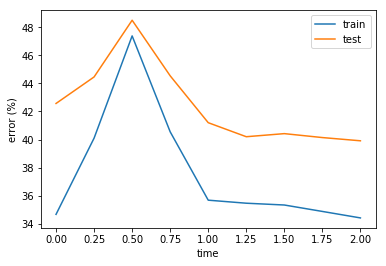

In [22]:
plt.plot(time, path['train'], label='train')
plt.plot(time, path['test'], label='test') 
plt.legend()
plt.xlabel('time')
plt.ylabel('error (%)')
plt.show()

In [23]:
path_l = {'test': [], 'train': []}
for t in tqdm(time):
    point = finder.find_point(t=t, method='lin_connect')
    path_l['test'].append(100-point['test']) 
    path_l['train'].append(100-point['train']) 

 11%|█         | 1/9 [00:20<02:43, 20.40s/it]

0.0 {'train': 65.33200000000001, 'test': 57.43000000000001}


 22%|██▏       | 2/9 [00:36<02:13, 19.12s/it]

0.25 {'train': 61.18599999999999, 'test': 55.879999999999995}


 33%|███▎      | 3/9 [00:52<01:49, 18.18s/it]

0.5 {'train': 51.078, 'test': 50.660000000000004}


 44%|████▍     | 4/9 [01:10<01:31, 18.21s/it]

0.75 {'train': 60.577999999999996, 'test': 55.88999999999999}


 56%|█████▌    | 5/9 [01:26<01:09, 17.37s/it]

1.0 {'train': 64.322, 'test': 58.8}


 67%|██████▋   | 6/9 [01:28<00:38, 12.72s/it]

1.25 {'train': 64.984, 'test': 60.58}


 78%|███████▊  | 7/9 [01:29<00:18,  9.38s/it]

1.5 {'train': 65.358, 'test': 60.61}


 89%|████████▉ | 8/9 [01:30<00:06,  6.96s/it]

1.75 {'train': 65.512, 'test': 60.51}


100%|██████████| 9/9 [01:32<00:00,  5.38s/it]

2.0 {'train': 65.586, 'test': 60.089999999999996}


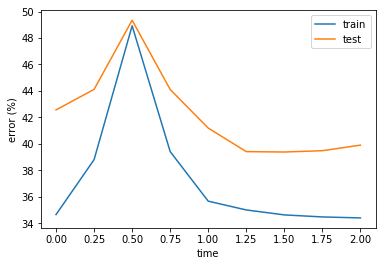

In [24]:
plt.plot(time, path_l['train'], label='train')
plt.plot(time, path_l['test'], label='test') 
plt.legend()
plt.xlabel('time')
plt.ylabel('error (%)')
plt.show()

# Count statistic in the fixed point

In [25]:
def get_stat(pointfinder, t=.5, method='arc_connect'):
    stat = {'test': [], 'train': []}
    for i in tqdm(range(1, 7)):
        model1.load_state_dict(torch.load('curves/'+model_name+'/curve'+str(i)+'/checkpoint-400.pt')['model_state'])
        model2.load_state_dict(torch.load('curves/'+model_name+'/curve'+str(i+1)+'/checkpoint-400.pt')['model_state'])
        finder = pointfinder(model1, model2) 
        point = finder.find_point(t=t, method=method)
        stat['test'].append(point['test']) 
        stat['train'].append(point['train']) 
    return stat

In [26]:
def get_mean_svd(stat):
    train = np.array(stat['train'])
    test = np.array(stat['test'])
    return train.mean(), train.std(), test.mean(), test.std()

In [27]:
linpseudo = get_stat(PointFinderInverse2, t=.5, method='lin_connect')

 17%|█▋        | 1/6 [00:23<01:59, 23.95s/it]

0.5 {'train': 50.808, 'test': 49.69}


 33%|███▎      | 2/6 [00:59<01:50, 27.55s/it]

0.5 {'train': 50.928, 'test': 50.23}


 50%|█████     | 3/6 [01:30<01:25, 28.61s/it]

0.5 {'train': 50.916, 'test': 49.04}


 67%|██████▋   | 4/6 [02:03<00:59, 29.86s/it]

0.5 {'train': 51.239999999999995, 'test': 49.66}


 83%|████████▎ | 5/6 [02:33<00:29, 29.83s/it]

0.5 {'train': 51.498, 'test': 49.63}


100%|██████████| 6/6 [03:05<00:00, 30.58s/it]

0.5 {'train': 51.086, 'test': 50.68}


In [28]:
linpseudo

{'test': [49.69, 50.23, 49.04, 49.66, 49.63, 50.68],
 'train': [50.808, 50.928, 50.916, 51.239999999999995, 51.498, 51.086]}

In [29]:
get_mean_svd(linpseudo)

(51.07933333333333, 0.2325013739505395, 49.82166666666666, 0.515539092170085)

In [30]:
arcpseudo = get_stat(PointFinderInverse2, t=.5, method='arc_connect')

 17%|█▋        | 1/6 [00:34<02:51, 34.22s/it]

0.5 {'train': 52.459999999999994, 'test': 50.580000000000005}


 33%|███▎      | 2/6 [01:06<02:15, 33.77s/it]

0.5 {'train': 52.244, 'test': 51.24999999999999}


 50%|█████     | 3/6 [01:33<01:34, 31.55s/it]

0.5 {'train': 52.402, 'test': 50.67}


 67%|██████▋   | 4/6 [02:06<01:04, 32.14s/it]

0.5 {'train': 52.26, 'test': 50.74999999999999}


 83%|████████▎ | 5/6 [02:36<00:31, 31.47s/it]

0.5 {'train': 52.717999999999996, 'test': 50.61}


100%|██████████| 6/6 [03:06<00:00, 31.10s/it]

0.5 {'train': 52.556000000000004, 'test': 51.42}


In [31]:
arcpseudo

{'test': [50.580000000000005,
  51.24999999999999,
  50.67,
  50.74999999999999,
  50.61,
  51.42],
 'train': [52.459999999999994,
  52.244,
  52.402,
  52.26,
  52.717999999999996,
  52.556000000000004]}

In [32]:
get_mean_svd(arcpseudo)

(52.44, 0.16502525059315395, 50.88, 0.32974737805376475)

In [ ]:
f_inv1 = np.linalg.pinv(funcs1.T)

In [ ]:
f_inv2 = np.linalg.pinv(funcs2.T)

In [62]:
pred = W12 @ np.maximum(W11 @ np.maximum(W10 @ data.T, 0), 0)
accuracy(pred.T, targ)

95.27799999999999

In [70]:
pred = W12 @ np.maximum(W11 @ np.maximum(W10 @ data.T, 0), 0)
accuracy(pred.T, targ)

95.27799999999999

In [64]:
t=0.5
pred = Connector(W12.T, W22.T).arc_connect(t=t)[1].T @ np.maximum(Connector(W11, (W21 @ funcs2.T @ f_inv1)).arc_connect(t=t)[1] @  np.maximum(W10 @ data.T, 0), 0)
accuracy(pred.T, targ)

61.07

In [65]:
t = 0.5
pred = W22 @ np.maximum(Connector((W21 @ funcs2.T @ f_inv1).T, W21.T).arc_connect(t=t)[1].T @ np.maximum(Connector(W10, W20).arc_connect(t=t)[1]  @ data.T, 0), 0)
accuracy(pred.T, targ)

78.448